# Imports and Functions

In [1]:
import math 
from sklearn.neural_network import MLPClassifier

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.backend_bases import MouseButton
import matplotlib.path as path
from matplotlib.colors import ListedColormap
import numpy as np
from numpy import load
import pandas as pd
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, ExtraTreesClassifier
from sklearn.neighbors import KDTree
%matplotlib notebook

global selection_model
global threshold
threshold = 20 #300 works
import random
from random import randint

global cm
global cm_bright
global wales
global maxiter
global numcoords
cm = plt.cm.RdBu
cm_bright = ListedColormap(['#FF0000', '#0000FF'])

wales = load('walesoutline1.npy')
wales = path.Path(wales)


maxiter = 21
numcoords = 2
selection_model = 1 #0 for 0.5, 1 for isolated, 2 for random, 3 for best

In [2]:
import math
def normpdf(x, mean, sd):
    var = float(sd)**2
    denom = (2*math.pi*var)**.5
    num = math.exp(-(float(x)-float(mean))**2/(2*var))
    return num/denom

In [3]:
def xnew(x): 
    return (-5)+(((x+5)*(10+5))/(51+5))
def ynew(y): 
    return ((y+2)*(15))/(55)

def branin(x, a=1, b=5.1/(4*(np.pi**2)), c=5/np.pi, r=6, s=10, t=1/(8*np.pi), noise=0.1):
       
    return a*(x[1]-(b*(x[0]**2))+c*x[0]-r)**2+(s*(1-t)*np.cos(x[0]))+s

def braninColor(x, threshold):
    
    if branin((xnew(x[0]),xnew(x[1])))>threshold:
        return 1
    else:
        return 0   

In [4]:
def calculateModel():
    
    global X
    global Z
    global Z_model_pred
    global Znew
    global ZBranin
    global xx,yy
    global Big_df
    global Big_df_land


    x_min, x_max = -5, 51 
    y_min, y_max = -2, 53
    h = .5  # step size in the mesh

    Coords_df = pd.DataFrame(coords,columns=['XPos','YPos','Type'])
    DT_X_Values = Coords_df.drop(['Type'],axis=1)

    X = DT_X_Values.to_numpy().tolist()
    X = np.array(X)

    DT_Y_Values = Coords_df.drop(['XPos'],axis=1)
    DT_Y_Values = DT_Y_Values.drop(['YPos'],axis=1)
    y = DT_Y_Values.to_numpy().ravel()



    clf = MLPClassifier(alpha=0.3, max_iter=3000, solver = 'lbfgs')
    clf.fit(X, y)
    
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
    
    ZBranin = []
    branincoords = np.c_[xx.ravel(), yy.ravel()]
    for i in range(12320):
        ZBranin.append(braninColor(branincoords[i],20))



    Z_model_prob = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]
    Z_model_prob = Z_model_prob.reshape(xx.shape)                                                      #Z is [model_probs]
    Z_model_pred = clf.predict(np.c_[xx.ravel(), yy.ravel()])[:]                        #Z_model_pred is [model_predictions]

    Big_df = pd.DataFrame(xx.ravel(), columns=['xx'])#
    Big_df.insert(1, 'yy',yy.ravel())
    Big_df.insert(2, 'Z_model_predictions', Z_model_pred.ravel())
    Big_df.insert(3, 'Z_model_predictions_flattened', 0)
    Big_df.insert(4, 'Z_model_probs', Z_model_prob.ravel())
    Big_df.insert(5, 'Z_model_probs_flattened_SEA', 0)
    Big_df.insert(6, 'Z_model_probs_flattened_0', 0)
    Big_df.insert(7, 'Surrogate_model_predictions', ZBranin)
    Big_df.insert(8, 'Surrogate_model_predictions_flattened', 0)

    for i in range(12320):

        if (wales.contains_points([(Big_df.iat[i,0],Big_df.iat[i,1])])[0]):
            Big_df.loc[i, 'Z_model_probs_flattened_SEA'] = Big_df.iloc[i]['Z_model_predictions']
            Big_df.loc[i, 'Z_model_probs_flattened_SEA'] = Big_df.iloc[i]['Z_model_probs']
            Big_df.loc[i, 'Surrogate_model_predictions_flattened'] = Big_df.iloc[i]['Surrogate_model_predictions']
            Big_df.loc[i, 'Z_model_probs_flattened_0'] = Big_df.iloc[i]['Z_model_probs']

        else:
            Big_df.loc[i, 'Z_model_predictions_flattened'] = 'SEA'
            Big_df.loc[i, 'Z_model_probs_flattened_SEA'] = 'SEA'
            Big_df.loc[i, 'Surrogate_model_predictions_flattened'] = 'SEA'
            Big_df.loc[i, 'Z_model_probs_flattened_0'] = 0

    Z_model_predictions = Big_df["Z_model_predictions"].to_numpy()
    Z_model_predictions_flattened = Big_df["Z_model_predictions_flattened"].to_numpy()
    Z_model_probs = Big_df["Z_model_probs"].to_numpy()
#     Z_model_probs_flattened = Big_df["Z_model_probs_flattened"].to_numpy()
    Surrogate_model_predictions = Big_df["Surrogate_model_predictions"].to_numpy()
    Surrogate_model_predictions_flattened = Big_df["Surrogate_model_predictions_flattened"].to_numpy()

    Big_df_land = Big_df[Big_df['Z_model_predictions_flattened'] != 'SEA']

    Contour_model = Big_df["Z_model_probs_flattened_0"].to_numpy()
    Contour_model = Contour_model.reshape(xx.shape) 


    plt.cla()
    img = plt.imread('WalesMap.png');
    ax.imshow(img, extent=[-5, 51, -2, 53])
    ax.scatter([x[0] for x in coords],[y[1] for y in coords], c= [z[2] for z in coords], cmap = 'seismic_r')
    # plt.axis("off")
    plt.grid()
    ax.contourf(xx, yy, Contour_model, 40, cmap=cm, alpha=
                0.4)

    plt.plot()

    plt.show()


In [5]:
def find_isolated_point():
       
    tree = KDTree(X, leaf_size=40)
    maxdist = 0
    maxind = -1
    ifinal = -1
    tmp_df = Big_df_land.iloc[::5, :]

    testpoints = tmp_df[['xx','yy']].to_numpy()

    for i in range(len(testpoints)):
        dist, ind = tree.query([testpoints.tolist()[i]], k=1)
        if dist>maxdist:
            maxdist = dist
            maxind = ind
            ifinal = i

    ax.scatter(testpoints[ifinal][0], testpoints[ifinal][1], c='#00FF00', s=25)
    plt.plot()
    plt.show()
    fig1.show()
#     print('isolated', testpoints[ifinal])
    return testpoints[ifinal]
    
def find0_5():
    
    tmp_df = Big_df.iloc[(Big_df['Z_model_probs_flattened_0']-0.50).abs().argsort()[:2]]
    value = randint(0, len(tmp_df.index)-1)
    uncertain_coord = [tmp_df.iloc[value]['xx'],tmp_df.iloc[value]['yy']]
        
    ax.scatter(uncertain_coord[0], uncertain_coord[1], c='#00FF00', s=25)
    plt.plot()
    plt.show()    
    fig1.show()
      
#     print('0_5', uncertain_coord)
    return uncertain_coord

def random_point():
    
    tmp_df = Big_df_land.iloc[:, :]
    testpoints = tmp_df[['xx','yy']].to_numpy()
                    
    ifinal = randint(0,len(testpoints.tolist()))
    
    ax.scatter(testpoints[ifinal][0], testpoints[ifinal][1], c='#00FF00', s=25)

    plt.plot()

    plt.show()
    
    fig1.show()
    
    return testpoints[ifinal]

def best():
    
    tree = KDTree(X, leaf_size=40)
    maxdist = 0
    maxind = -1
    ifinal = -1
    tmp_df = Big_df_land.iloc[::5, :]
    score = 0

    testpoints = tmp_df[['xx','yy']].to_numpy()
    testpoints1 = tmp_df[['Z_model_probs']].to_numpy()

    for i in range(len(testpoints)):
        dist, ind = tree.query([testpoints.tolist()[i]], k=1)
        prob = testpoints1[i]
        tmp_score = dist*normpdf(prob,0.5,0.05)
        if tmp_score>score:
            ifinal = i
            distfinal = dist
            probfinal = prob
            score = tmp_score

    ax.scatter(testpoints[ifinal][0], testpoints[ifinal][1], c='#00FF00', s=25)

    plt.plot()

    plt.show()

    fig1.show()
    
    find0_5()
    find_isolated_point()
    
    print(distfinal)
    print(probfinal)
    print(score)
    print('best',testpoints[ifinal])

    return testpoints[ifinal]
    
    



In [6]:
def Accuracy():
    
    correctPredictions = 0
    incorrectPredictions = 0

    for i in range(len(Big_df_land.index)):
        if ((Big_df_land.iloc[i]["Z_model_predictions"])==(Big_df_land.iloc[i]["Surrogate_model_predictions"])):
            correctPredictions+=1
        else:
            incorrectPredictions+=1


    accuracy = (correctPredictions)/((
    incorrectPredictions+correctPredictions))
    accuracyArray.append(accuracy)

    print('Accuracy is',accuracy)
    

def printGraph():
    
    xAxis = []
    for i in range(len(accuracyArray)):
        xAxis.append(i+1)

    plt.scatter(xAxis, accuracyArray) 
    plt.xlabel('Iterations')
    plt.ylabel('Accuracy')
    plt.title('Model Accuracy over time')
    plt.ylim(0.3, 1.0)  
    plt.show()

# Plot first graph

experiment:  0


<IPython.core.display.Javascript object>


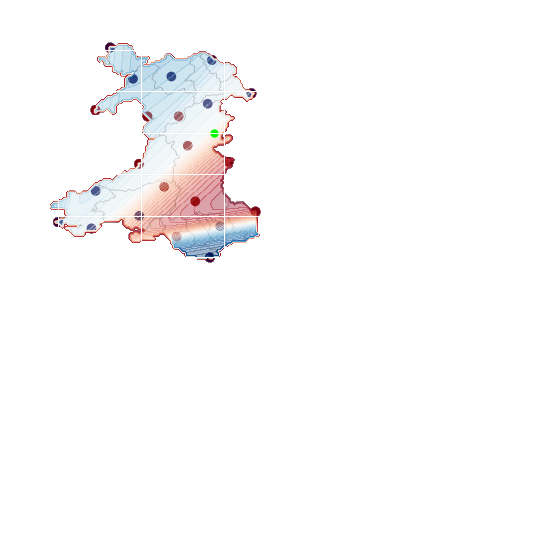

iteration  1
Accuracy is 0.5671986156508364
iteration  2
Accuracy is 0.5810421072870602
iteration  3
Accuracy is 0.6158431070947895
iteration  4
Accuracy is 0.5673908863680062
iteration  5
Accuracy is 0.5118246491059412
iteration  6
Accuracy is 0.5610459527014036
iteration  7
Accuracy is 0.5796962122668717
iteration  8
Accuracy is 0.6294943280138435
iteration  9
Accuracy is 0.6700634493366661
iteration  10
Accuracy is 0.4845222072678331
iteration  11
Accuracy is 0.5345125937319746
iteration  12
Accuracy is 0.5454720246106518
iteration  13
Accuracy is 0.5993078254181888
iteration  14
Accuracy is 0.6904441453566622
iteration  15
Accuracy is 0.8150355700826765
iteration  16
Accuracy is 0.6283407037108248
iteration  17
Accuracy is 0.6398769467410114
iteration  18
Accuracy is 0.6629494328013843
iteration  19
Accuracy is 0.6635262449528937
iteration  20
Accuracy is 0.702557200538358
iteration  21
Accuracy is 0.6996731397808114
experiment:  1


<IPython.core.display.Javascript object>


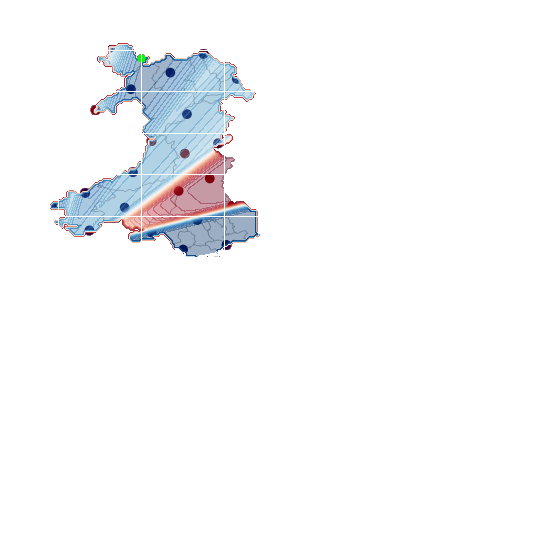

iteration  1
Accuracy is 0.5049029032878293
iteration  2
Accuracy is 0.6848682945587387
iteration  3
Accuracy is 0.6654489521245914
iteration  4
Accuracy is 0.681215150932513
iteration  5
Accuracy is 0.5929628917515862
iteration  6
Accuracy is 0.562391847721592
iteration  7
Accuracy is 0.5773889636608345
iteration  8
Accuracy is 0.5775812343780042
iteration  9
Accuracy is 0.6193039800038455
iteration  10
Accuracy is 0.5979619303980004
iteration  11
Accuracy is 0.6193039800038455
iteration  12
Accuracy is 0.6646798692559123
iteration  13
Accuracy is 0.6692943664679869
iteration  14
Accuracy is 0.6627571620842145
iteration  15
Accuracy is 0.6954431840030764
iteration  16
Accuracy is 0.6942895597000577
iteration  17
Accuracy is 0.6990963276293021
iteration  18
Accuracy is 0.7000576812151509
iteration  19
Accuracy is 0.706787156316093
iteration  20
Accuracy is 0.7069794270332629
iteration  21
Accuracy is 0.7040953662757162
experiment:  2


<IPython.core.display.Javascript object>


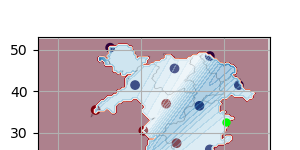

iteration  1
Accuracy is 0.44568352239953857
iteration  2
Accuracy is 0.6629494328013843
iteration  3
Accuracy is 0.6940972889828879
iteration  4
Accuracy is 0.690636416073832
iteration  5
Accuracy is 0.5681599692366852
iteration  6
Accuracy is 0.5425879638531051
iteration  7
Accuracy is 0.5685445106710248
iteration  8
Accuracy is 0.6323783887713901
iteration  9
Accuracy is 0.6533358969428956
iteration  10
Accuracy is 0.5698904056912132
iteration  11
Accuracy is 0.645260526821765
iteration  12
Accuracy is 0.6656412228417612
iteration  13
Accuracy is 0.6933282061142088
iteration  14
Accuracy is 0.6533358969428956
iteration  15
Accuracy is 0.6946741011343972
iteration  16
Accuracy is 0.6962122668717554
iteration  17
Accuracy is 0.7012113055181696
iteration  18
Accuracy is 0.6262257258219573
iteration  19
Accuracy is 0.7010190348009998
iteration  20
Accuracy is 0.6160353778119593
iteration  21
Accuracy is 0.6892905210536435
experiment:  3


<IPython.core.display.Javascript object>


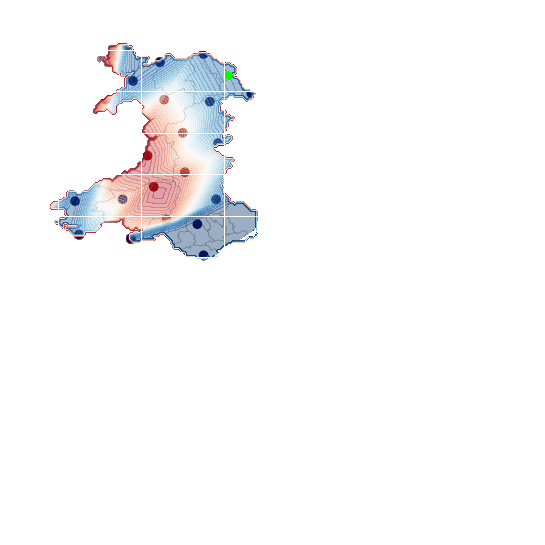

iteration  1
Accuracy is 0.5462411074793309
iteration  2
Accuracy is 0.634108825225918
iteration  3
Accuracy is 0.5577773505095174
iteration  4
Accuracy is 0.5662372620649875
iteration  5
Accuracy is 0.6260334551047876
iteration  6
Accuracy is 0.5489328975197078
iteration  7
Accuracy is 0.5964237646606422
iteration  8
Accuracy is 0.5846952509132859
iteration  9
Accuracy is 0.5993078254181888
iteration  10
Accuracy is 0.48817535089405883
iteration  11
Accuracy is 0.604306864064603
iteration  12
Accuracy is 0.5166314170351856
iteration  13
Accuracy is 0.499134781772736
iteration  14
Accuracy is 0.5498942511055567
iteration  15
Accuracy is 0.6010382618727168
iteration  16
Accuracy is 0.5448952124591425
iteration  17
Accuracy is 0.5135550855604691
iteration  18
Accuracy is 0.58123437800423
iteration  19
Accuracy is 0.5387425495097097
iteration  20


F:\Anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Accuracy is 0.8090751778504134
iteration  21
Accuracy is 0.7731205537396655
experiment:  4


<IPython.core.display.Javascript object>


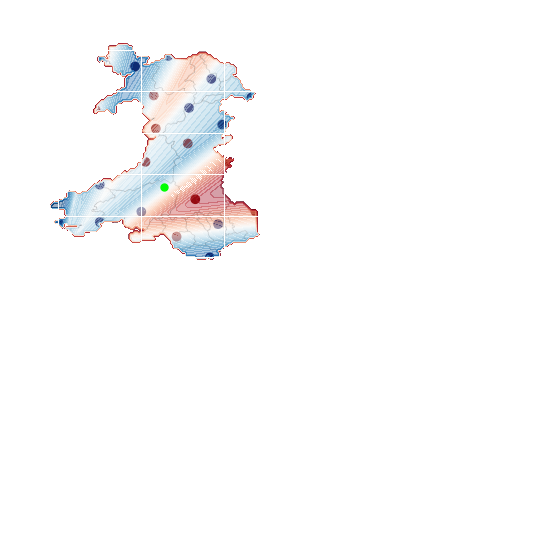

iteration  1
Accuracy is 0.6041145933474332
iteration  2
Accuracy is 0.6039223226302635
iteration  3
Accuracy is 0.6260334551047876
iteration  4
Accuracy is 0.6208421457412037
iteration  5
Accuracy is 0.5883483945395116
iteration  6
Accuracy is 0.6300711401653528
iteration  7
Accuracy is 0.5431647760046145
iteration  8
Accuracy is 0.6154585656604499
iteration  9
Accuracy is 0.5541242068832917
iteration  10
Accuracy is 0.5402807152470679
iteration  11
Accuracy is 0.5625841184387618
iteration  12
Accuracy is 0.5427802345702749
iteration  13
Accuracy is 0.576043068640646
iteration  14
Accuracy is 0.6879446260334551
iteration  15
Accuracy is 0.5727744664487598
iteration  16
Accuracy is 0.5352816766006537
iteration  17
Accuracy is 0.6404537588925207
iteration  18
Accuracy is 0.6508363776196885
iteration  19
Accuracy is 0.6739088636800615
iteration  20
Accuracy is 0.6398769467410114
iteration  21
Accuracy is 0.6567967698519516
experiment:  5


<IPython.core.display.Javascript object>


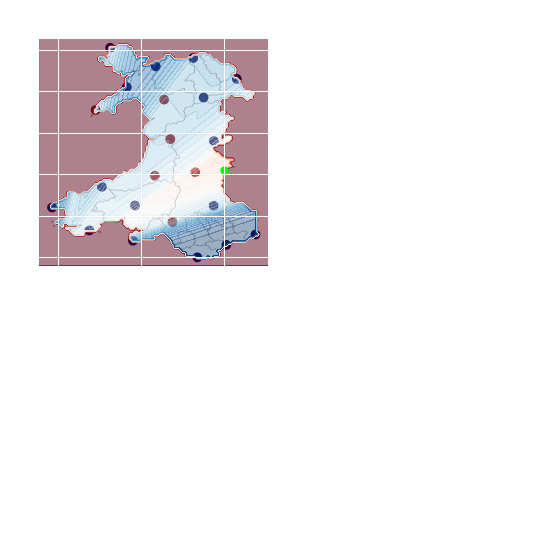

iteration  1
Accuracy is 0.38415689290521055
iteration  2
Accuracy is 0.4847144779850029
iteration  3
Accuracy is 0.5985387425495097
iteration  4
Accuracy is 0.5998846375696981
iteration  5
Accuracy is 0.43049413574312634
iteration  6
Accuracy is 0.4877908094597193
iteration  7
Accuracy is 0.5127860026917901
iteration  8
Accuracy is 0.41318977119784656
iteration  9
Accuracy is 0.43780042299557775
iteration  10
Accuracy is 0.44549125168236875
iteration  11
Accuracy is 0.4431840030763315
iteration  12
Accuracy is 0.5054797154393386
iteration  13
Accuracy is 0.6150740242261103
iteration  14
Accuracy is 0.5866179580849836
iteration  15
Accuracy is 0.6150740242261103
iteration  16
Accuracy is 0.6150740242261103
iteration  17
Accuracy is 0.6150740242261103
iteration  18
Accuracy is 0.6912132282253413
iteration  19
Accuracy is 0.688905979619304
iteration  20
Accuracy is 0.6973658911747741
iteration  21
Accuracy is 0.6791001730436454
experiment:  6


<IPython.core.display.Javascript object>


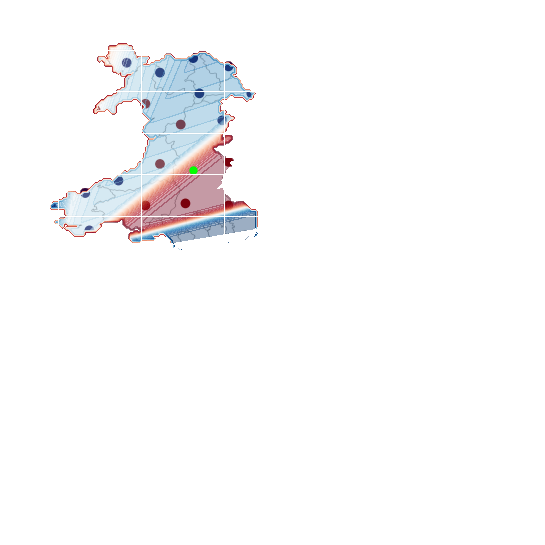

iteration  1
Accuracy is 0.5587387040953663
iteration  2
Accuracy is 0.5733512786002691
iteration  3
Accuracy is 0.6383387810036532
iteration  4
Accuracy is 0.5033647375504711
iteration  5
Accuracy is 0.5979619303980004
iteration  6
Accuracy is 0.6579503941549703
iteration  7
Accuracy is 0.6519900019227072
iteration  8
Accuracy is 0.6602576427610075
iteration  9
Accuracy is 0.6604499134781773
iteration  10
Accuracy is 0.6614112670640262
iteration  11
Accuracy is 0.6550663333974236
iteration  12
Accuracy is 0.6208421457412037
iteration  13
Accuracy is 0.6433378196500673
iteration  14
Accuracy is 0.5846952509132859
iteration  15
Accuracy is 0.6406460296096904
iteration  16
Accuracy is 0.6143049413574313
iteration  17
Accuracy is 0.6419919246298789
iteration  18
Accuracy is 0.6354547202461065
iteration  19
Accuracy is 0.6419919246298789
iteration  20
Accuracy is 0.6810228802153432
iteration  21
Accuracy is 0.6998654104979811
experiment:  7


<IPython.core.display.Javascript object>


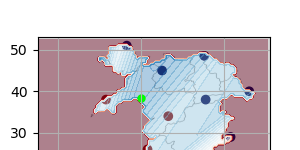

iteration  1
Accuracy is 0.635070178811767
iteration  2
Accuracy is 0.6029609690444145
iteration  3
Accuracy is 0.665833493558931
iteration  4
Accuracy is 0.5835416266102672
iteration  5
Accuracy is 0.661603537781196
iteration  6
Accuracy is 0.688905979619304
iteration  7
Accuracy is 0.6467986925591233
iteration  8
Accuracy is 0.49105941165160544
iteration  9
Accuracy is 0.5323976158431071
iteration  10
Accuracy is 0.6004614497212074
iteration  11
Accuracy is 0.6262257258219573
iteration  12
Accuracy is 0.6915977696596808
iteration  13
Accuracy is 0.6708325322053451
iteration  14
Accuracy is 0.6446837146702558
iteration  15
Accuracy is 0.6973658911747741
iteration  16
Accuracy is 0.6885214381849645
iteration  17
Accuracy is 0.6235339357815805
iteration  18
Accuracy is 0.6093059027110171
iteration  19
Accuracy is 0.6012305325898866
iteration  20
Accuracy is 0.6791001730436454
iteration  21
Accuracy is 0.7021726591040185
experiment:  8


<IPython.core.display.Javascript object>


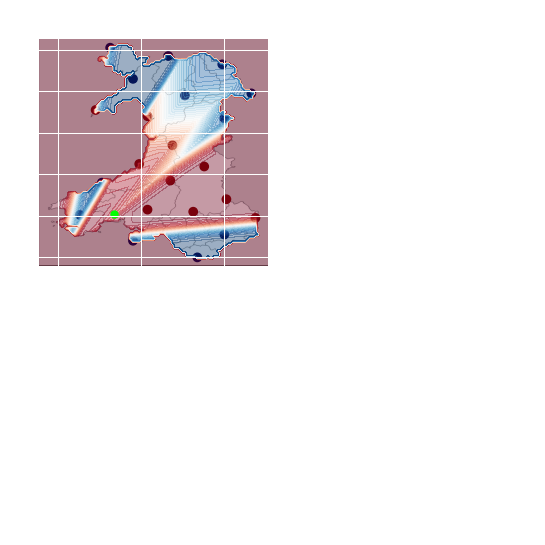

iteration  1
Accuracy is 0.551240146125745
iteration  2
Accuracy is 0.562391847721592
iteration  3
Accuracy is 0.6362238031147857
iteration  4
Accuracy is 0.6971736204576043
iteration  5
Accuracy is 0.6458373389732743
iteration  6
Accuracy is 0.6244952893674294
iteration  7
Accuracy is 0.6062295712363007
iteration  8
Accuracy is 0.6200730628725245
iteration  9
Accuracy is 0.6091136319938474
iteration  10
Accuracy is 0.6260334551047876
iteration  11
Accuracy is 0.5575850797923476
iteration  12
Accuracy is 0.6150740242261103
iteration  13
Accuracy is 0.5591232455297058
iteration  14
Accuracy is 0.6492982118823303
iteration  15
Accuracy is 0.6031532397615843
iteration  16
Accuracy is 0.6429532782157278
iteration  17
Accuracy is 0.6035377811959238
iteration  18
Accuracy is 0.6915977696596808
iteration  19
Accuracy is 0.6877523553162853
iteration  20
Accuracy is 0.6929436646798692
iteration  21
Accuracy is 0.7269755816189194
experiment:  9


<IPython.core.display.Javascript object>


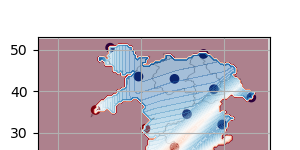

iteration  1
Accuracy is 0.5943087867717747
iteration  2
Accuracy is 0.5368198423380119
iteration  3
Accuracy is 0.5016343010959431
iteration  4
Accuracy is 0.5318208036915978
iteration  5
Accuracy is 0.5352816766006537
iteration  6
Accuracy is 0.6962122668717554
iteration  7
Accuracy is 0.6762161122860988
iteration  8
Accuracy is 0.6767929244376082
iteration  9
Accuracy is 0.6450682561045953
iteration  10
Accuracy is 0.6006537204383773
iteration  11
Accuracy is 0.6644875985387425
iteration  12
Accuracy is 0.6360315323976159
iteration  13
Accuracy is 0.6294943280138435
iteration  14


F:\Anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Accuracy is 0.6373774274178042
iteration  15
Accuracy is 0.565852720630648
iteration  16
Accuracy is 0.5866179580849836
iteration  17
Accuracy is 0.5483560853681985
iteration  18
Accuracy is 0.6712170736396846
iteration  19
Accuracy is 0.6508363776196885
iteration  20
Accuracy is 0.6227648529129014
iteration  21
Accuracy is 0.6083445491251682
experiment:  10


<IPython.core.display.Javascript object>


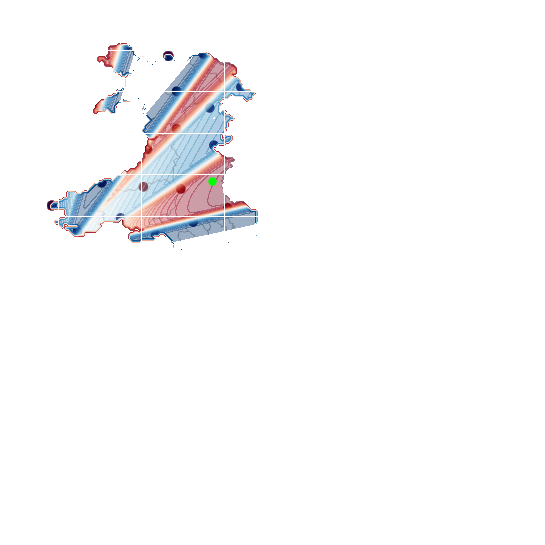

iteration  1
Accuracy is 0.5612382234185733
iteration  2
Accuracy is 0.5429725052874447
iteration  3
Accuracy is 0.6150740242261103
iteration  4
Accuracy is 0.5621995770044222
iteration  5
Accuracy is 0.5637377427417805
iteration  6
Accuracy is 0.5329744279946165
iteration  7
Accuracy is 0.5545087483176312
iteration  8
Accuracy is 0.576043068640646
iteration  9
Accuracy is 0.49298211882330323
iteration  10
Accuracy is 0.6310324937512017
iteration  11
Accuracy is 0.6435300903672371
iteration  12
Accuracy is 0.6489136704479908
iteration  13
Accuracy is 0.6554508748317631
iteration  14
Accuracy is 0.6416073831955393
iteration  15
Accuracy is 0.6492982118823303
iteration  16
Accuracy is 0.639300134589502
iteration  17
Accuracy is 0.6666025764276101
iteration  18
Accuracy is 0.6933282061142088
iteration  19
Accuracy is 0.6379542395693136
iteration  20
Accuracy is 0.639300134589502
iteration  21
Accuracy is 0.644491443953086
experiment:  11


<IPython.core.display.Javascript object>


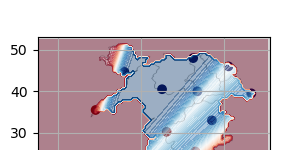

iteration  1
Accuracy is 0.48490674870217265
iteration  2
Accuracy is 0.5193232070755623
iteration  3
Accuracy is 0.5235531628532974
iteration  4
Accuracy is 0.5125937319746202
iteration  5
Accuracy is 0.5160546048836763
iteration  6
Accuracy is 0.5781580465295135
iteration  7
Accuracy is 0.6275716208421458
iteration  8
Accuracy is 0.656412228417612
iteration  9
Accuracy is 0.6467986925591233
iteration  10
Accuracy is 0.6277638915593156
iteration  11
Accuracy is 0.6356469909632763
iteration  12
Accuracy is 0.6840992116900596
iteration  13
Accuracy is 0.634108825225918
iteration  14
Accuracy is 0.6166121899634686
iteration  15
Accuracy is 0.6119976927513939
iteration  16
Accuracy is 0.619688521438185
iteration  17
Accuracy is 0.6716016150740243
iteration  18
Accuracy is 0.6750624879830802
iteration  19
Accuracy is 0.6727552393770428
iteration  20
Accuracy is 0.6537204383772351
iteration  21
Accuracy is 0.6742934051144011
experiment:  12


<IPython.core.display.Javascript object>


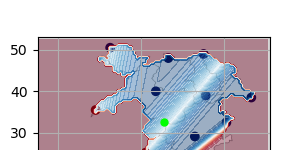

iteration  1
Accuracy is 0.39011728513747357
iteration  2
Accuracy is 0.389732743703134
iteration  3
Accuracy is 0.5124014612574505
iteration  4
Accuracy is 0.5124014612574505
iteration  5
Accuracy is 0.5566237262064988
iteration  6
Accuracy is 0.5604691405498943
iteration  7
Accuracy is 0.560661411267064
iteration  8
Accuracy is 0.5652759084791387
iteration  9
Accuracy is 0.6191117092866757
iteration  10
Accuracy is 0.6400692174581811
iteration  11
Accuracy is 0.6591040184579888
iteration  12
Accuracy is 0.6531436262257259
iteration  13
Accuracy is 0.679484714477985
iteration  14
Accuracy is 0.7096712170736397
iteration  15
Accuracy is 0.6741011343972313
iteration  16
Accuracy is 0.6539127090944049
iteration  17
Accuracy is 0.7106325706594886
iteration  18
Accuracy is 0.7194770236492982
iteration  19
Accuracy is 0.7133243606998654
iteration  20
Accuracy is 0.7150547971543934
iteration  21
Accuracy is 0.7158238800230725
experiment:  13


<IPython.core.display.Javascript object>


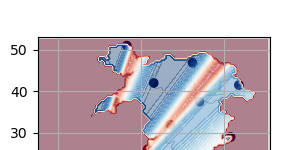

iteration  1
Accuracy is 0.5193232070755623
iteration  2
Accuracy is 0.5241299750048067
iteration  3
Accuracy is 0.5450874831763123
iteration  4
Accuracy is 0.5766198807921553
iteration  5
Accuracy is 0.5252835993078254
iteration  6
Accuracy is 0.5275908479138627
iteration  7
Accuracy is 0.48529129013651223
iteration  8
Accuracy is 0.49951932320707554
iteration  9
Accuracy is 0.506825610459527
iteration  10
Accuracy is 0.6237262064987502
iteration  11
Accuracy is 0.6456450682561046
iteration  12
Accuracy is 0.6721784272255336
iteration  13
Accuracy is 0.6546817919630841
iteration  14
Accuracy is 0.6750624879830802
iteration  15
Accuracy is 0.6589117477408191
iteration  16
Accuracy is 0.6902518746394924
iteration  17
Accuracy is 0.6892905210536435
iteration  18
Accuracy is 0.6900596039223227
iteration  19
Accuracy is 0.6639107863872332
iteration  20
Accuracy is 0.6548740626802538
iteration  21
Accuracy is 0.6587194770236493
experiment:  14


<IPython.core.display.Javascript object>


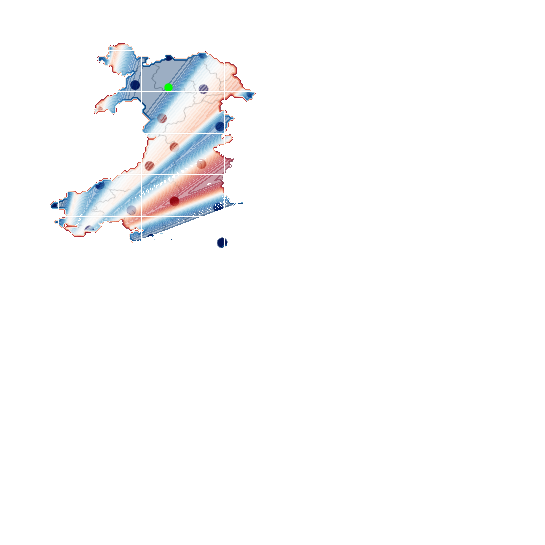

iteration  1
Accuracy is 0.4226110363391655
iteration  2
Accuracy is 0.5066333397423572
iteration  3
Accuracy is 0.5056719861565083
iteration  4
Accuracy is 0.5420111517015959
iteration  5
Accuracy is 0.5814266487213997
iteration  6
Accuracy is 0.5996923668525284
iteration  7
Accuracy is 0.6023841568929053
iteration  8
Accuracy is 0.5149009805806576
iteration  9
Accuracy is 0.5118246491059412
iteration  10
Accuracy is 0.5525860411459335
iteration  11
Accuracy is 0.6143049413574313
iteration  12
Accuracy is 0.5560469140549894
iteration  13
Accuracy is 0.6118054220342242
iteration  14
Accuracy is 0.6362238031147857
iteration  15
Accuracy is 0.6862141895789271
iteration  16
Accuracy is 0.648721399730821
iteration  17
Accuracy is 0.6492982118823303
iteration  18
Accuracy is 0.6908286867910017
iteration  19
Accuracy is 0.6900596039223227
iteration  20
Accuracy is 0.6873678138819458
iteration  21
Accuracy is 0.6250721015189387
experiment:  15


<IPython.core.display.Javascript object>


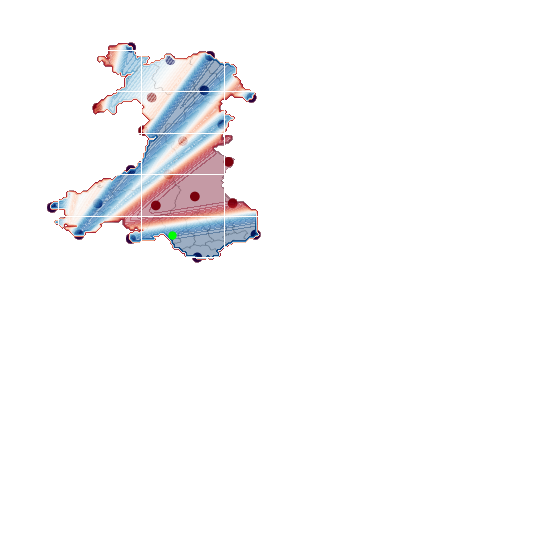

iteration  1
Accuracy is 0.6423764660642184
iteration  2
Accuracy is 0.6439146318015766
iteration  3
Accuracy is 0.5729667371659296
iteration  4
Accuracy is 0.5254758700249952
iteration  5
Accuracy is 0.6216112286098827
iteration  6
Accuracy is 0.6865987310132666
iteration  7
Accuracy is 0.6919823110940204
iteration  8
Accuracy is 0.6890982503364738
iteration  9
Accuracy is 0.6542972505287444
iteration  10
Accuracy is 0.565852720630648
iteration  11
Accuracy is 0.5798884829840415
iteration  12
Accuracy is 0.5710440299942319
iteration  13
Accuracy is 0.6429532782157278
iteration  14
Accuracy is 0.6881368967506248
iteration  15
Accuracy is 0.6787156316093059
iteration  16
Accuracy is 0.7073639684676024
iteration  17
Accuracy is 0.6994808690636416
iteration  18
Accuracy is 0.6973658911747741
iteration  19
Accuracy is 0.689675062487983
iteration  20
Accuracy is 0.6656412228417612
iteration  21
Accuracy is 0.6394924053066718
experiment:  16


<IPython.core.display.Javascript object>


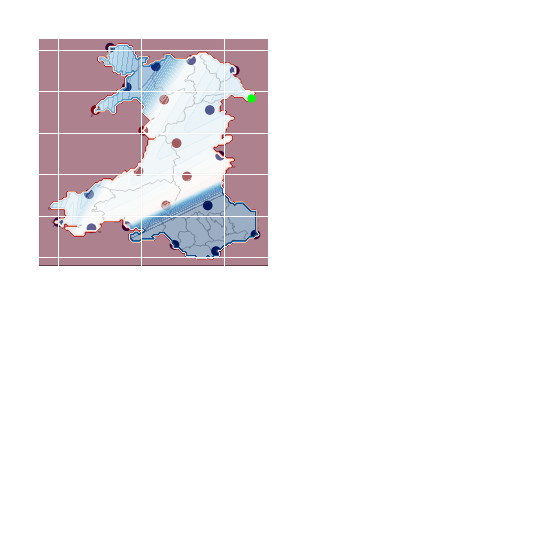

iteration  1
Accuracy is 0.500865218227264
iteration  2
Accuracy is 0.5837338973274371
iteration  3
Accuracy is 0.5725821957315901
iteration  4
Accuracy is 0.620457604306864
iteration  5
Accuracy is 0.5595077869640454
iteration  6
Accuracy is 0.6146894827917708
iteration  7
Accuracy is 0.5147087098634878
iteration  8
Accuracy is 0.4351086329552009
iteration  9
Accuracy is 0.4524129975004807
iteration  10
Accuracy is 0.4353009036723707
iteration  11
Accuracy is 0.4331859257835032
iteration  12
Accuracy is 0.4614497212074601
iteration  13
Accuracy is 0.5414343395500866
iteration  14
Accuracy is 0.5460488367621611
iteration  15
Accuracy is 0.5298980965199
iteration  16
Accuracy is 0.49182849452028454
iteration  17
Accuracy is 0.5014420303787733
iteration  18
Accuracy is 0.5695058642568737
iteration  19
Accuracy is 0.6318015766198808
iteration  20
Accuracy is 0.6746779465487406
iteration  21
Accuracy is 0.6525668140742165
experiment:  17


<IPython.core.display.Javascript object>


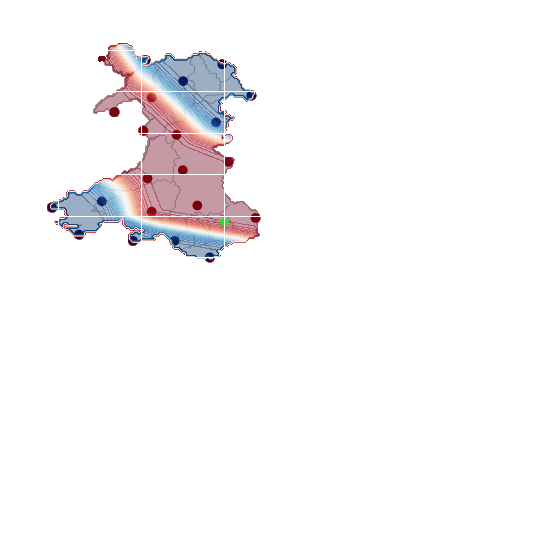

iteration  1
Accuracy is 0.5466256489136705
iteration  2
Accuracy is 0.5485483560853682
iteration  3
Accuracy is 0.5781580465295135
iteration  4
Accuracy is 0.5500865218227264
iteration  5
Accuracy is 0.5941165160546049
iteration  6
Accuracy is 0.6223803114785618
iteration  7
Accuracy is 0.5702749471255528
iteration  8
Accuracy is 0.7494712555277832
iteration  9
Accuracy is 0.7502403383964622
iteration  10
Accuracy is 0.7429340511440108
iteration  11
Accuracy is 0.600845991155547
iteration  12
Accuracy is 0.5804652951355509
iteration  13
Accuracy is 0.6083445491251682
iteration  14
Accuracy is 0.6373774274178042
iteration  15
Accuracy is 0.6119976927513939
iteration  16
Accuracy is 0.6144972120746011
iteration  17
Accuracy is 0.6544895212459142
iteration  18
Accuracy is 0.6621803499327052
iteration  19
Accuracy is 0.6573735820034609
iteration  20
Accuracy is 0.6304556815996923
iteration  21
Accuracy is 0.7931167083253221
experiment:  18


<IPython.core.display.Javascript object>


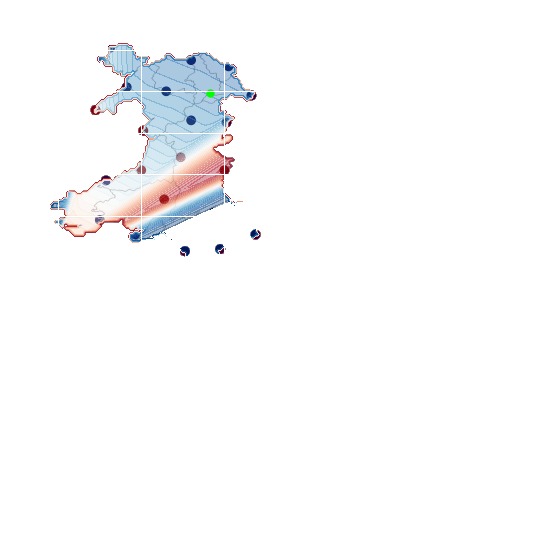

iteration  1
Accuracy is 0.39300134589502017
iteration  2
Accuracy is 0.49855796962122667
iteration  3
Accuracy is 0.5595077869640454
iteration  4
Accuracy is 0.6075754662564892
iteration  5
Accuracy is 0.6004614497212074
iteration  6
Accuracy is 0.5989232839838493
iteration  7
Accuracy is 0.5998846375696981
iteration  8
Accuracy is 0.605075946933282
iteration  9
Accuracy is 0.6150740242261103
iteration  10
Accuracy is 0.6150740242261103
iteration  11
Accuracy is 0.6150740242261103
iteration  12
Accuracy is 0.6150740242261103
iteration  13
Accuracy is 0.6227648529129014
iteration  14
Accuracy is 0.6191117092866757
iteration  15
Accuracy is 0.6702557200538358
iteration  16
Accuracy is 0.6814074216496827
iteration  17
Accuracy is 0.6833301288213806
iteration  18
Accuracy is 0.6398769467410114
iteration  19
Accuracy is 0.5945010574889444
iteration  20
Accuracy is 0.6183426264179965
iteration  21
Accuracy is 0.6168044606806383
experiment:  19


<IPython.core.display.Javascript object>


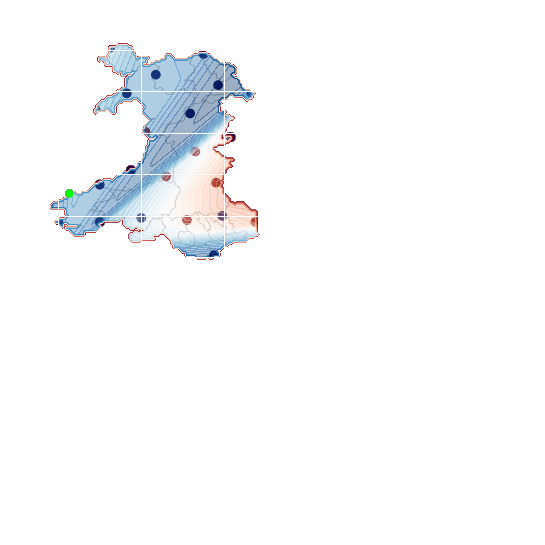

iteration  1
Accuracy is 0.4412612959046337
iteration  2
Accuracy is 0.4391463180157662
iteration  3
Accuracy is 0.545279753893482
iteration  4
Accuracy is 0.5412420688329167
iteration  5
Accuracy is 0.5416266102672563
iteration  6
Accuracy is 0.5662372620649875
iteration  7
Accuracy is 0.5873870409536628
iteration  8
Accuracy is 0.6635262449528937
iteration  9
Accuracy is 0.549509709671217
iteration  10
Accuracy is 0.5281676600653721
iteration  11
Accuracy is 0.6539127090944049
iteration  12
Accuracy is 0.6483368582964815
iteration  13
Accuracy is 0.6881368967506248
iteration  14
Accuracy is 0.6627571620842145
iteration  15
Accuracy is 0.6625648913670448
iteration  16
Accuracy is 0.6489136704479908
iteration  17
Accuracy is 0.6733320515285522
iteration  18
Accuracy is 0.6723706979427033
iteration  19
Accuracy is 0.6725629686598731
iteration  20
Accuracy is 0.6704479907710056
iteration  21
Accuracy is 0.6833301288213806
experiment:  20


<IPython.core.display.Javascript object>


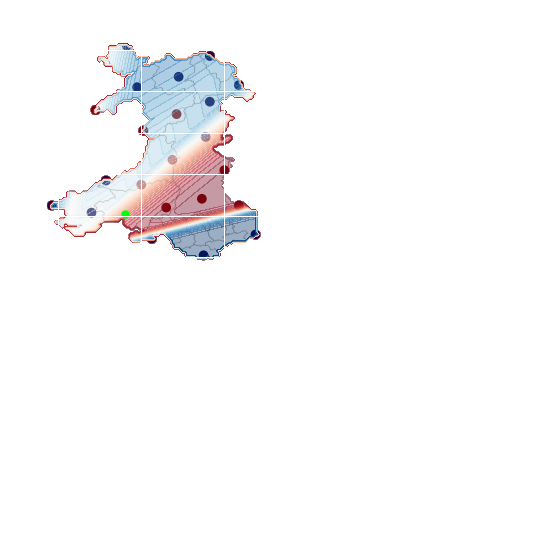

iteration  1
Accuracy is 0.5654681791963084
iteration  2
Accuracy is 0.5525860411459335
iteration  3
Accuracy is 0.6383387810036532
iteration  4
Accuracy is 0.5712363007114016
iteration  5
Accuracy is 0.6218034993270525
iteration  6
Accuracy is 0.6133435877715824
iteration  7
Accuracy is 0.6106517977312056
iteration  8
Accuracy is 0.6862141895789271
iteration  9
Accuracy is 0.6815996923668526
iteration  10
Accuracy is 0.6552586041145934
iteration  11
Accuracy is 0.5960392232263027
iteration  12
Accuracy is 0.622188040761392
iteration  13
Accuracy is 0.5966160353778119
iteration  14
Accuracy is 0.6219957700442222
iteration  15
Accuracy is 0.6208421457412037
iteration  16
Accuracy is 0.691405498942511
iteration  17
Accuracy is 0.6650644106902519
iteration  18
Accuracy is 0.6381465102864834
iteration  19
Accuracy is 0.6546817919630841
iteration  20
Accuracy is 0.6787156316093059
iteration  21
Accuracy is 0.6881368967506248


In [7]:
from random import randint
import time

valid_seeds = [4,27,12,15,17,21,23,24,25,28,31,32,35,36,37,41,42,43,45,48,420]

Results = []

for j in range(len(valid_seeds)):
    
    random.seed(valid_seeds[j])

    print('experiment: ',j)                            

    num = 100
    x = np.linspace(-5, 51, num)
    y = np.linspace(-2, 53, num)
    global landpoints 
    landpoints = []

    for i in range(num):
        for j in range(num):
            if wales.contains_points([(x[i],y[j])]):
                landpoints.append([x[i],y[j]])

    landpoints = np.asarray(landpoints, dtype=np.float32)

    i=0 
    coords = []

    for i in range(numcoords):
        value = randint(0, landpoints.size/2)
        coords.append((landpoints[value][0],
                            landpoints[value][1],
                            braninColor(landpoints[value],threshold)))
        i+=1

    global fig1,ax
    fig1, ax = plt.subplots(figsize = (3,3))
    ax.set_xlim(-5,51)
    ax.set_ylim(-2,53)
    img = plt.imread('WalesMap.png');
    ax.imshow(img, extent=[-5, 51, -2, 53])
    ax.scatter([x[0] for x in coords],[y[1] for y in coords], c= [z[2] for z in coords], cmap = 'seismic')
    # plt.axis("off")
    plt.grid()
    # cid = fig1.canvas.mpl_connect('button_press_event', Helicopter)

    fig1.show()
    fig1.canvas.draw()

    global accuracyArray
    accuracyArray = []

    for i in range(maxiter):
        plt.pause(1)
        print('iteration ',i+1)
    #     print('Calculating Model... ')
        calculateModel()
        plt.pause(1)
        fig1.canvas.draw()    
        Accuracy()
    #     print('Finding Isolated Point')
        if(i!=maxiter):
                     #0 for 0.5, 1 for isolated, 2 for random

            if(selection_model == 0):    
                nextpoint = find0_5()
            elif(selection_model==1):
                nextpoint=find_isolated_point()
            elif(selection_model==2):
                nextpoint = random_point()
            elif(selection_model==3):
                nextpoint = best()
            plt.pause(1)
            fig1.canvas.draw()
            coords.append((nextpoint[0], nextpoint[1], braninColor(nextpoint,threshold)))  
            plt.pause(1)
            fig1.canvas.draw()

    plt.close()
    
    Results.append(accuracyArray)
    
    

In [8]:
print('Highest Accuracy =',"{:.2f}".format((max(accuracyArray)*100)),'%')
print('Improvement is =', "{:.2f}".format((max(accuracyArray)-accuracyArray[0])*100),'%')

Highest Accuracy = 69.14 %
Improvement is = 12.59 %


In [9]:
Results

[[0.5671986156508364,
  0.5810421072870602,
  0.6158431070947895,
  0.5673908863680062,
  0.5118246491059412,
  0.5610459527014036,
  0.5796962122668717,
  0.6294943280138435,
  0.6700634493366661,
  0.4845222072678331,
  0.5345125937319746,
  0.5454720246106518,
  0.5993078254181888,
  0.6904441453566622,
  0.8150355700826765,
  0.6283407037108248,
  0.6398769467410114,
  0.6629494328013843,
  0.6635262449528937,
  0.702557200538358,
  0.6996731397808114],
 [0.5049029032878293,
  0.6848682945587387,
  0.6654489521245914,
  0.681215150932513,
  0.5929628917515862,
  0.562391847721592,
  0.5773889636608345,
  0.5775812343780042,
  0.6193039800038455,
  0.5979619303980004,
  0.6193039800038455,
  0.6646798692559123,
  0.6692943664679869,
  0.6627571620842145,
  0.6954431840030764,
  0.6942895597000577,
  0.6990963276293021,
  0.7000576812151509,
  0.706787156316093,
  0.7069794270332629,
  0.7040953662757162],
 [0.44568352239953857,
  0.6629494328013843,
  0.6940972889828879,
  0.6906364

In [13]:
np.savetxt('BraninIsolatednn', Results)

In [11]:
tst = np.loadtxt('BraninIsolated')

<IPython.core.display.Javascript object>


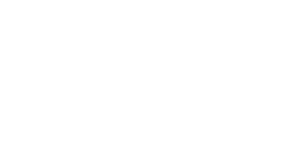

In [12]:
import random
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np
import seaborn as sns

# define a and b here
a = tst
b = []
for i in range(21):
    b.append(i+1)

# Helps pick a random color for each plot, used for readability
rand = lambda: random.randint(0, 255)
fig = plt.figure(figsize=(10,7.5))
ax = fig.add_subplot(111)
ax.set(ylim=(0.4, 1))

for ydata in a:
    clr = '#%02X%02X%02X' % (rand(),rand(),rand())
    plot, = ax.plot(b, ydata, color=clr, alpha = 0.2)
    sns.boxplot(data=tst)